Let us show that velocity estimation based on slam-seq data gives more consistent and clean results. 
Note that this is irrespective of the velocity tools you will use. Original scSLAM-seq authors show that velocyto gives better results when using slam-seq data. Here I am using the same result with the recently improved scvelo package. Please come back to see the result with dynamo! 

In [1]:
import pandas as pd 
import numpy as np 

import dynamo as dyn

# data from Hendriks et al. 2018 

Let us first run velocity estimation based on splicing data

use wget to download the raw_data_loom_combined file and then load the loom data 

wget https://www.dropbox.com/s/a9ozcynpxudqdis/raw_data_loom_combined.loom?dl=1

here I just use data I have in my local directory

In [2]:
adata_MCMV = dyn.read_loom('/home/xqiu/proj/dynamo/notebook_data/raw_data_loom_combined.loom')

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [3]:
# add a treatment label to the adata_MCMV object
import re
batch = list()

for cell in adata_MCMV.obs.index.values:
    regex = re.compile('3LF70')
    result = regex.search(cell)
    if result is not None:
        label = 'mock'
    else:
        label = 'mcmv'
    batch.append(label)

# add it to the adata_MCMV object
adata_MCMV.obs['virus'] = np.array(batch)

In [4]:
adata_MCMV

AnnData object with n_obs × n_vars = 1146 × 56007 
    obs: 'virus'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

/home/xqiu/.local/lib/python3.6/site-packages/dynamo-0.0+07100a0-py3.6.egg/dynamo/tools/dynamics.py:102: UserWarning: dynamo detects the experiment type of your data as conventional, but your input experiment_type is None
  'is {}'.format(exp_type, experiment_type))
/home/xqiu/.local/lib/python3.6/site-packages/scipy/sparse/_index.py:118: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/home/xqiu/.local/lib/python3.6/site-packages/anndata/core/anndata.py:1475: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning


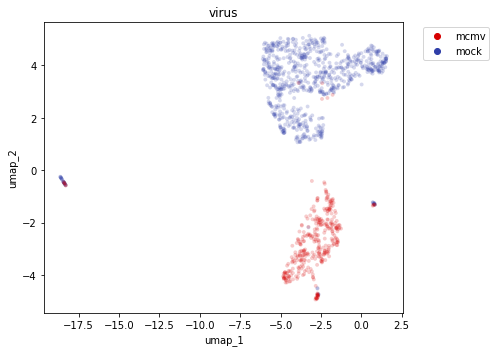

In [5]:
# scv.pp.filter_and_normalize(adata_MCMV, min_counts=15, min_counts_u=10, n_top_genes=500) # n_top_genes can be tuned 
# scv.pp.moments(adata_MCMV, n_pcs = 10, n_neighbors = 15, mode = 'distances') # 
# scv.tl.velocity(adata_MCMV)
# scv.tl.velocity_graph(adata_MCMV)

# scv.tl.umap(adata_MCMV)
# sc.pl.umap(adata_MCMV, color=['virus'])

dyn.pp.recipe_monocle(adata_MCMV, n_top_genes=1000)
dyn.tl.dynamics(adata_MCMV, mode='moment')
dyn.tl.reduceDimension(adata_MCMV)

dyn.pl.umap(adata_MCMV, color='virus')

/home/xqiu/.local/lib/python3.6/site-packages/anndata/core/anndata.py:1475: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning


<Figure size 432x288 with 0 Axes>

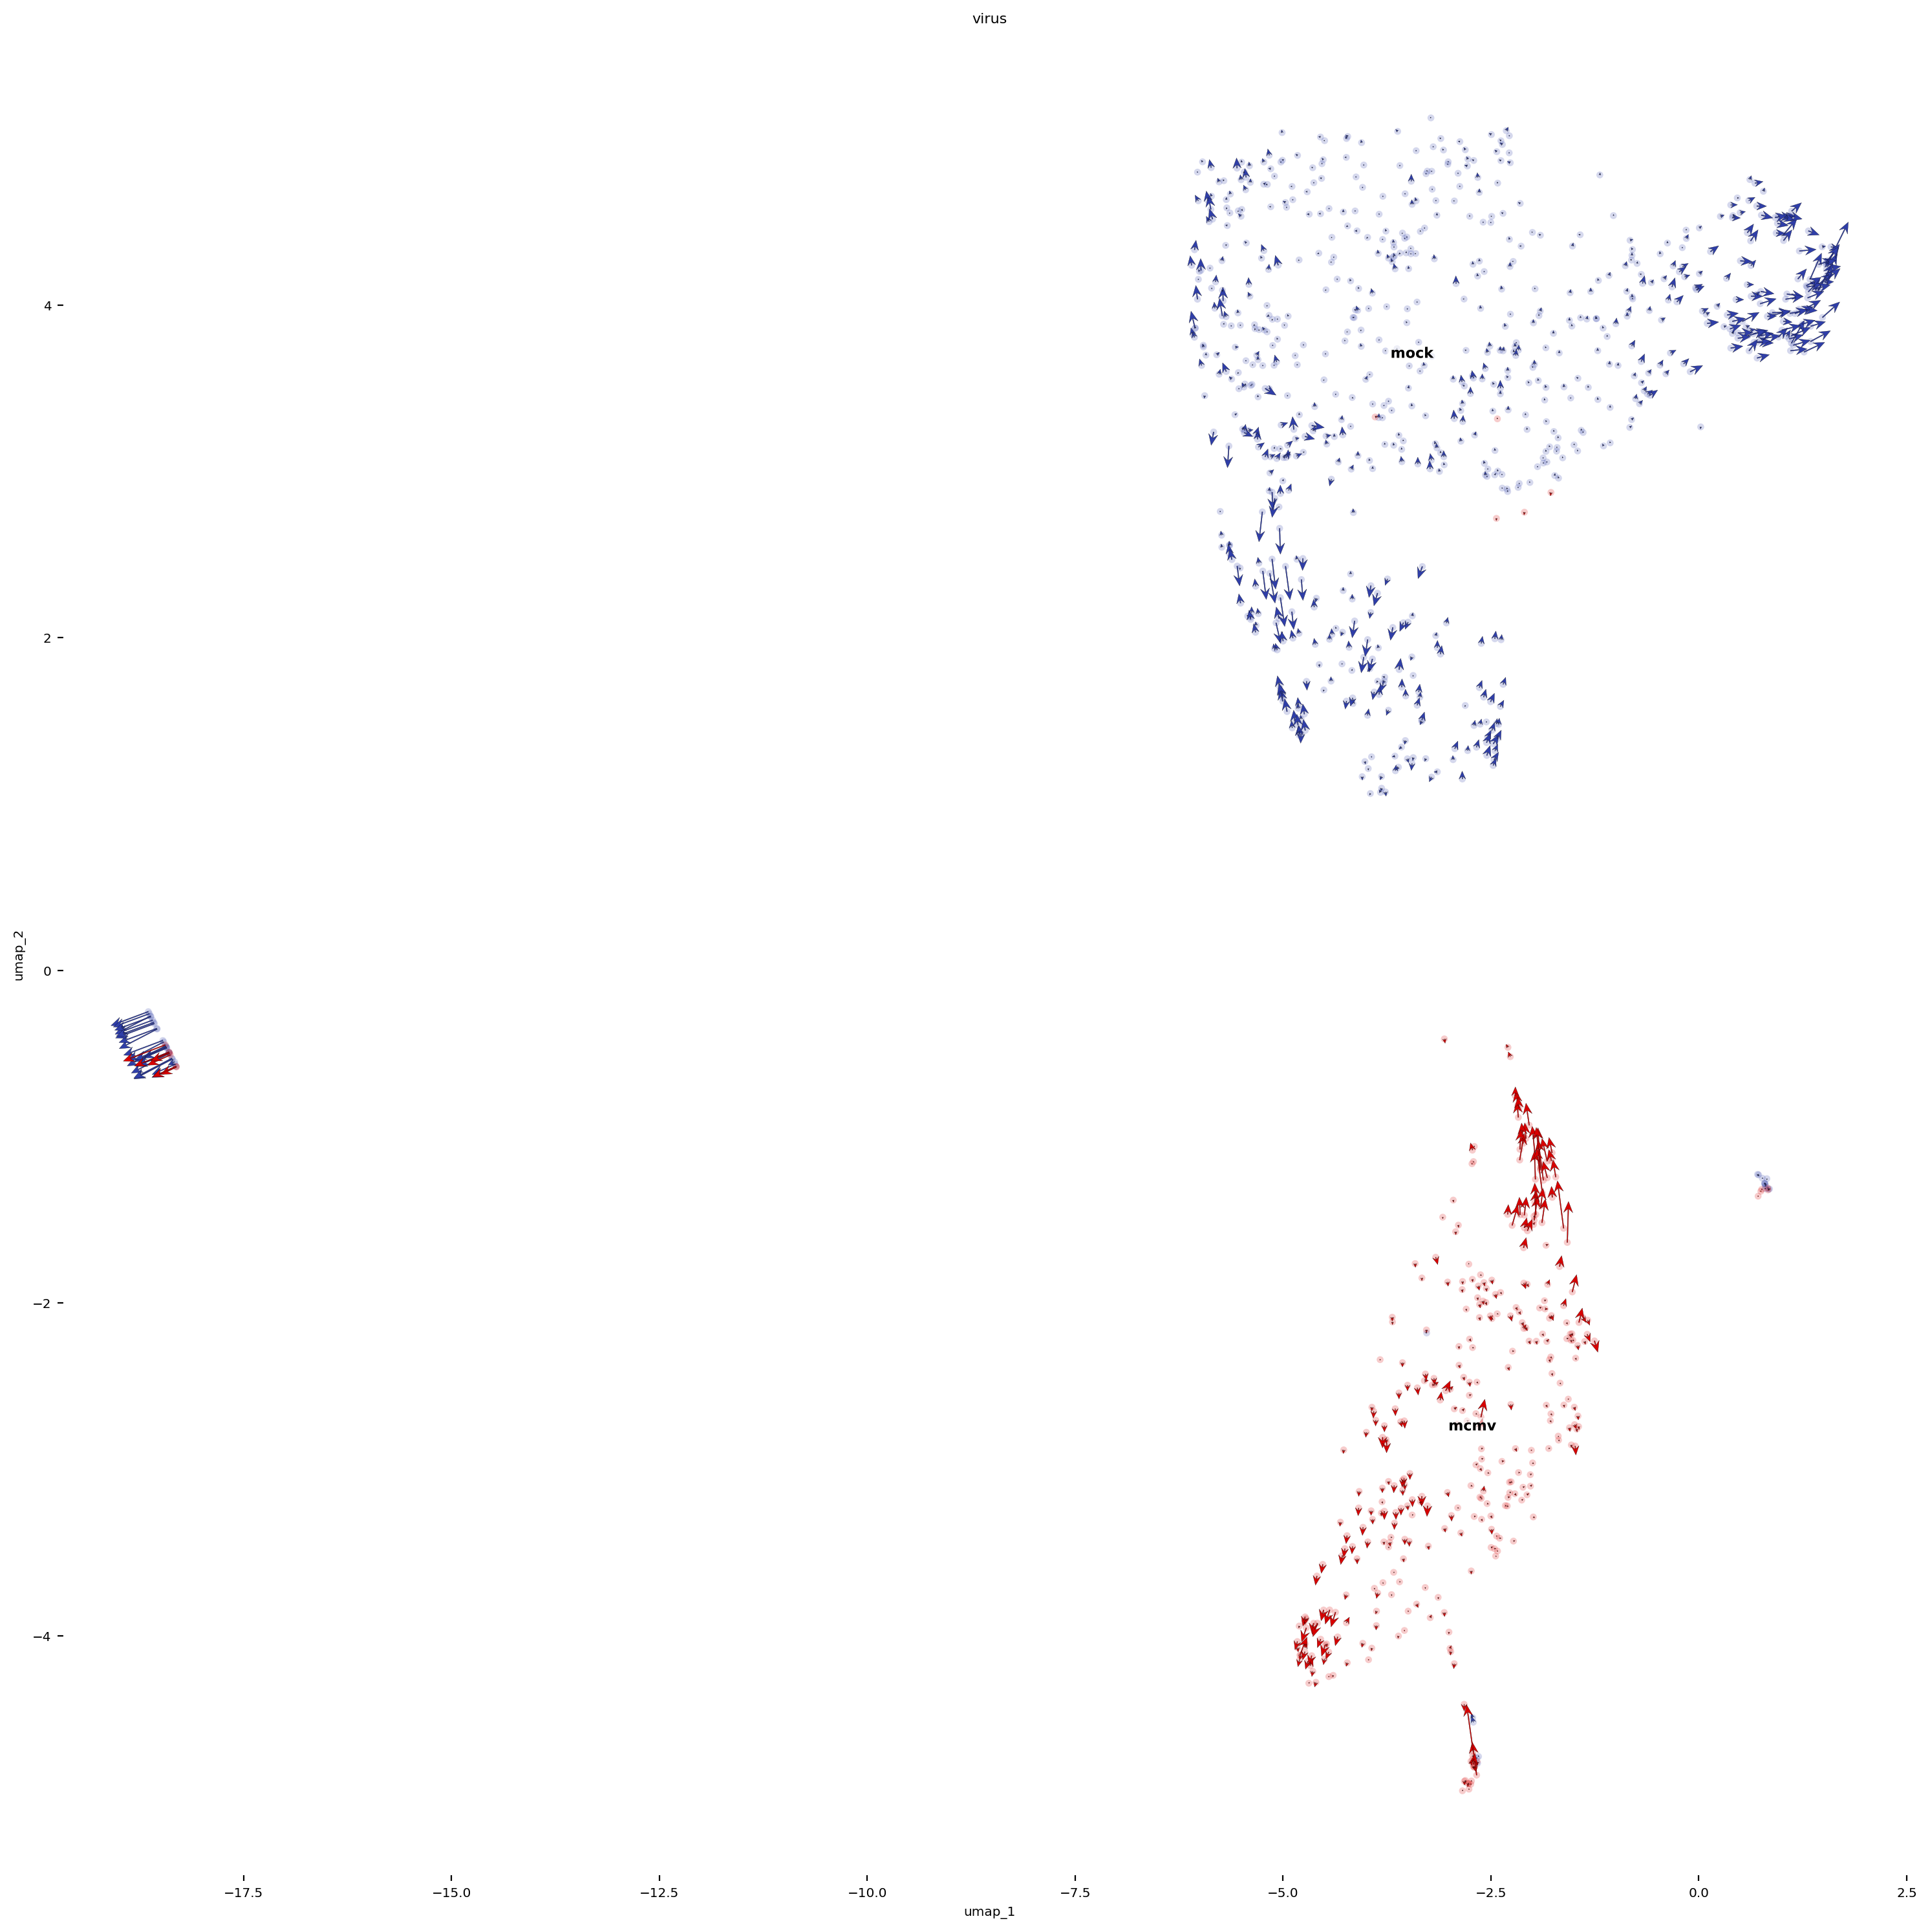

In [6]:
# # scv.tl.umap(adata_slamseq)
# scv.tl.velocity_graph(adata_MCMV)
# scv.pl.velocity_embedding(adata_MCMV, color=['virus'], basis='umap', figsize=[6, 6])

# scv.pl.velocity_embedding_grid(adata_MCMV, color=['virus'], basis='umap', figsize=[6, 6])

import dynamo as dyn 
dyn.tl.cell_velocities(adata_MCMV)
# dyn.pl.phase_portraits(adata_MCMV, genes=['RERE', 'ENO1', 'DHRS3'], ncols=3, figsize=(3, 3))
dyn.pl.cell_wise_velocity(adata_MCMV, color=['virus'], basis='umap', quiver_scale=2, show_legend='on data', figsize=[15, 15]) # ['GRIA3', 'LINC00982', 'AFF2']


/home/xqiu/.local/lib/python3.6/site-packages/anndata/core/anndata.py:1475: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning


<Figure size 650x500 with 0 Axes>

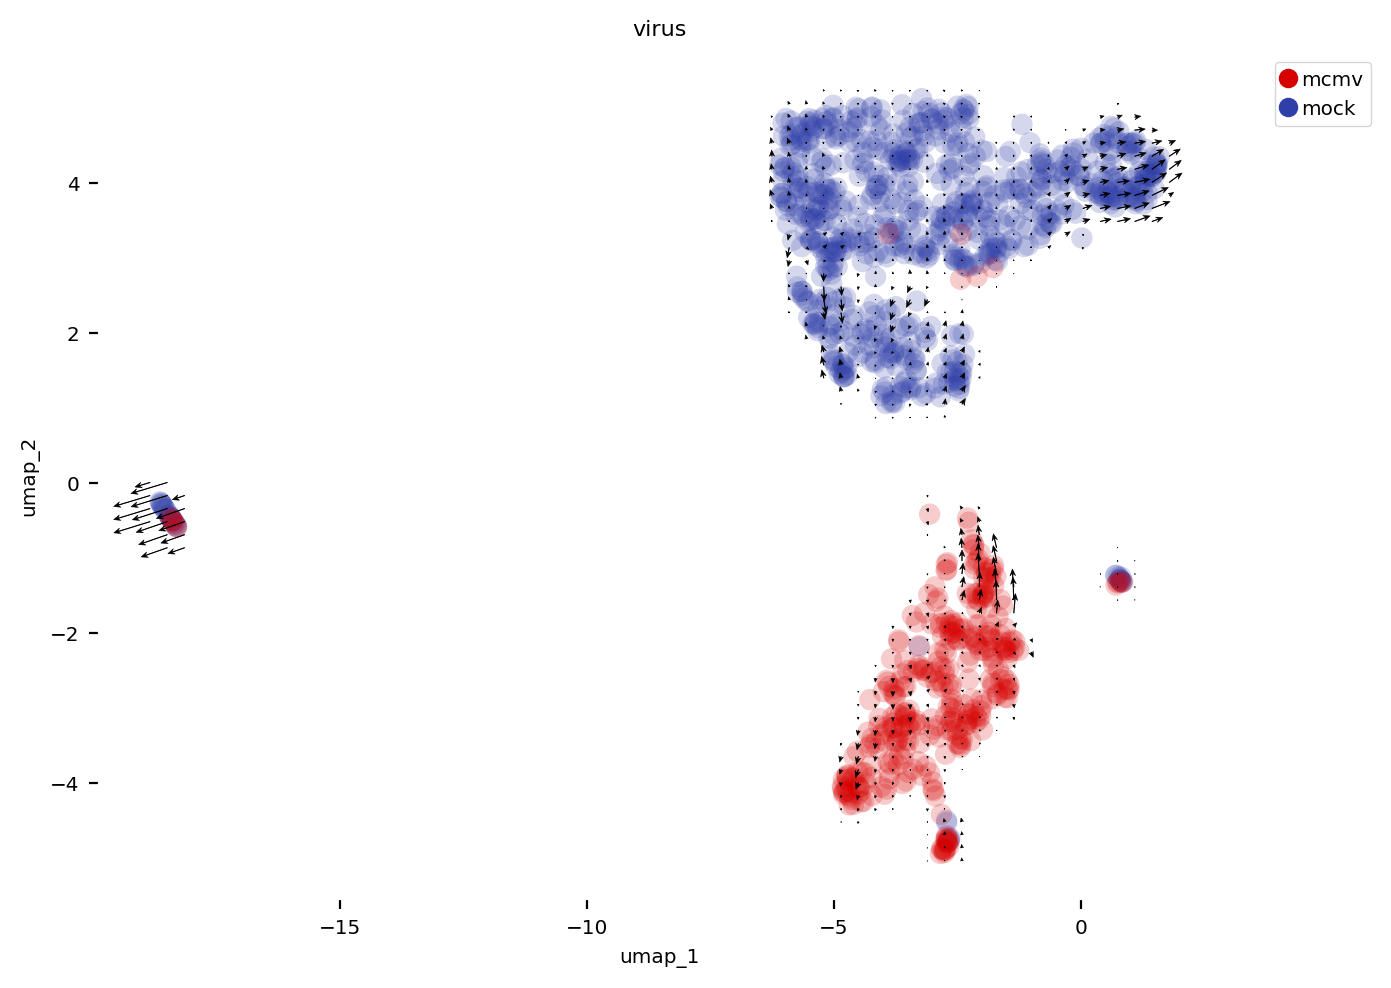

In [7]:
dyn.pl.grid_velocity(adata_MCMV, color=['virus'], basis='umap', method='gaussian', xy_grid_nums=(60,60)) # ['GRIA3', 'LINC00982', 'AFF2']


/home/xqiu/.local/lib/python3.6/site-packages/anndata/core/anndata.py:1475: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning


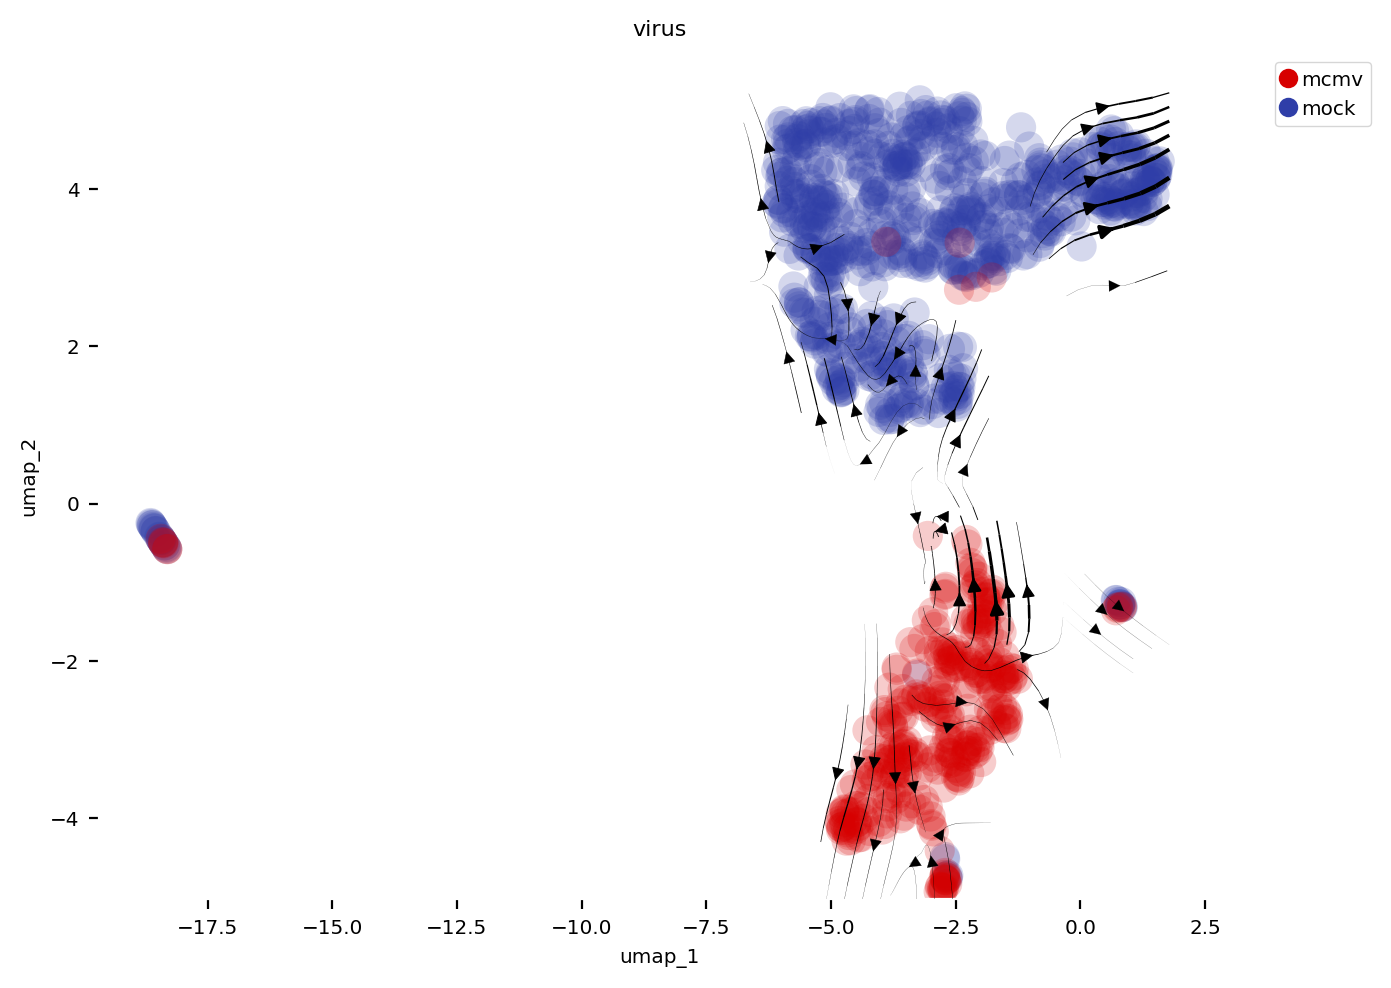

In [8]:
dyn.pl.streamline_plot(adata_MCMV, color=['virus'], basis='umap', method='gaussian', density=2) # ['GRIA3', 'LINC00982', 'AFF2']

/home/xqiu/.local/lib/python3.6/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/home/xqiu/.local/lib/python3.6/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


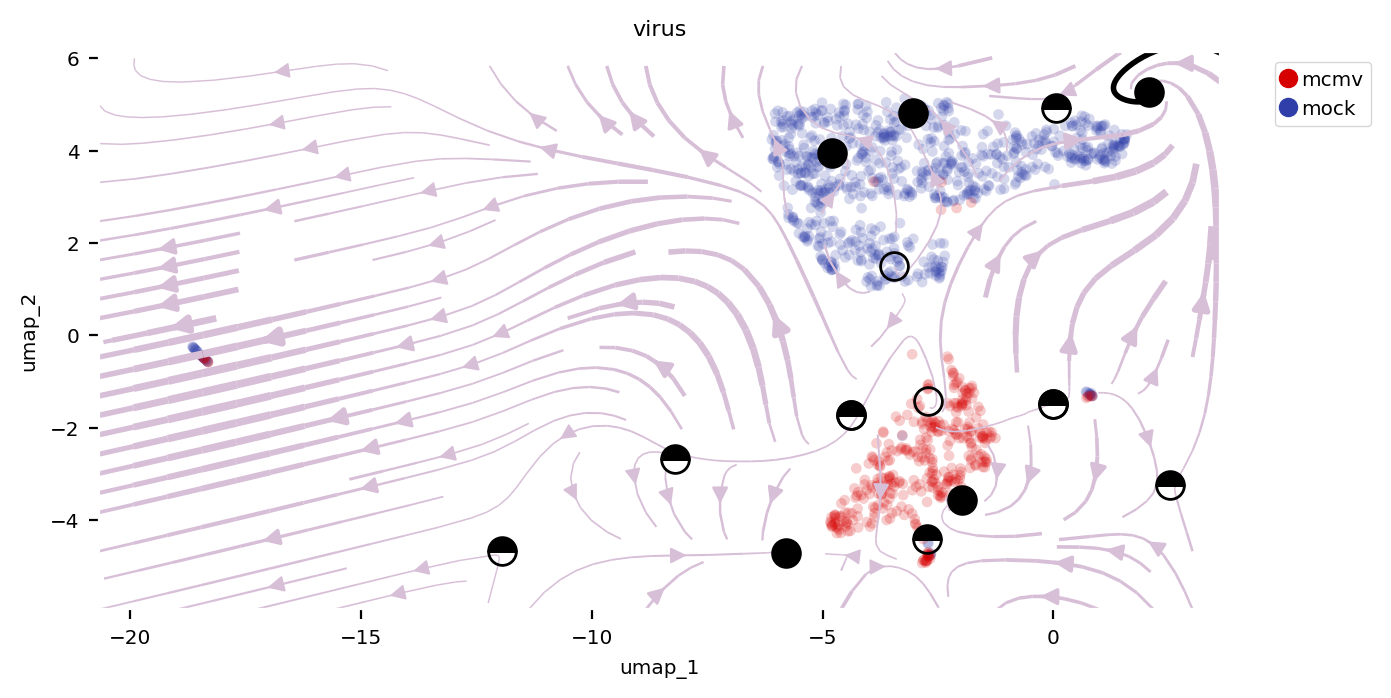

In [9]:
# dyn.pl.phase_portraits(adata_MCMV, genes=['Npc2', 'Psme2b', 'Fosl2', 'Mcl1'], ncols=3, figsize=(3, 3))
dyn.tl.VectorField(adata_MCMV)
dyn.pl.topography(adata_MCMV, color=['virus'], basis='umap', terms=('streamline', 'fixed_points', 'trajectory'), init_state = np.array([10, 0]))


The above velocity estimation results are kind messy. Next, let us try velocity estimation based on scSLAM-seq data. 

Note that we use total RNA (labelled new RNA + unlabeled old RNA) as **spliced** while the new RNA as **unspliced**

In [10]:
tot_RNA = pd.read_csv('https://www.dropbox.com/s/skgesrran9d48oy/emat_tot.txt?dl=1', index_col=0, delimiter='\s')
new_RNA = pd.read_csv('https://www.dropbox.com/s/kz0xj8hw4tbab9r/smat_new.txt?dl=1', index_col=0, delimiter='\s')

from anndata import AnnData
adata_sc_slamseq_MCMV = AnnData(tot_RNA.values.T,
    layers=dict(
        unspliced=new_RNA.values.T,
        spliced = tot_RNA.values.T)) 
adata_sc_slamseq_MCMV

# again, let annotate cells by virus infection
batch = list()

for cell in tot_RNA.columns.values:
    regex = re.compile('mock')
    result = regex.search(cell)
    if result is not None:
        label = 'mock'
    else:
        label = 'mcmv'
    batch.append(label)
    
# add it to the vlm object
adata_sc_slamseq_MCMV.obs['virus'] = np.array(batch)
adata_sc_slamseq_MCMV

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


AnnData object with n_obs × n_vars = 87 × 583 
    obs: 'virus'
    layers: 'unspliced', 'spliced'

In [11]:
dyn.pp.recipe_monocle(adata_sc_slamseq_MCMV, n_top_genes=583, fg_kwargs={'shared_count': 0})
adata_sc_slamseq_MCMV

AnnData object with n_obs × n_vars = 87 × 583 
    obs: 'virus', 'Size_Factor', 'spliced_Size_Factor', 'unspliced_Size_Factor', 'use_for_dynamo'
    var: 'pass_basic_filter', 'use_for_dynamo'
    uns: 'explained_variance_ratio_', 'pca_fit', 'feature_selection'
    obsm: 'X_pca'
    layers: 'unspliced', 'spliced'

In [12]:
adata_sc_slamseq_MCMV.layers['X_unspliced'], adata_sc_slamseq_MCMV.layers['X_spliced'] = adata_sc_slamseq_MCMV.layers['unspliced'], adata_sc_slamseq_MCMV.layers['spliced']

In [13]:
adata_sc_slamseq_MCMV

AnnData object with n_obs × n_vars = 87 × 583 
    obs: 'virus', 'Size_Factor', 'spliced_Size_Factor', 'unspliced_Size_Factor', 'use_for_dynamo'
    var: 'pass_basic_filter', 'use_for_dynamo'
    uns: 'explained_variance_ratio_', 'pca_fit', 'feature_selection'
    obsm: 'X_pca'
    layers: 'unspliced', 'spliced', 'X_unspliced', 'X_spliced'

/home/xqiu/.local/lib/python3.6/site-packages/dynamo-0.0+07100a0-py3.6.egg/dynamo/tools/dynamics.py:102: UserWarning: dynamo detects the experiment type of your data as conventional, but your input experiment_type is None
  'is {}'.format(exp_type, experiment_type))
/home/xqiu/.local/lib/python3.6/site-packages/scipy/sparse/_index.py:118: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/home/xqiu/.local/lib/python3.6/site-packages/dynamo-0.0+07100a0-py3.6.egg/dynamo/tools/utils.py:342: RuntimeWarning: divide by zero encountered in true_divide
  adata.var.loc[valid_ind, kin_param_pre + 'half_life'] = np.log(2) / gamma
/home/xqiu/.local/lib/python3.6/site-packages/anndata/core/anndata.py:1475: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning


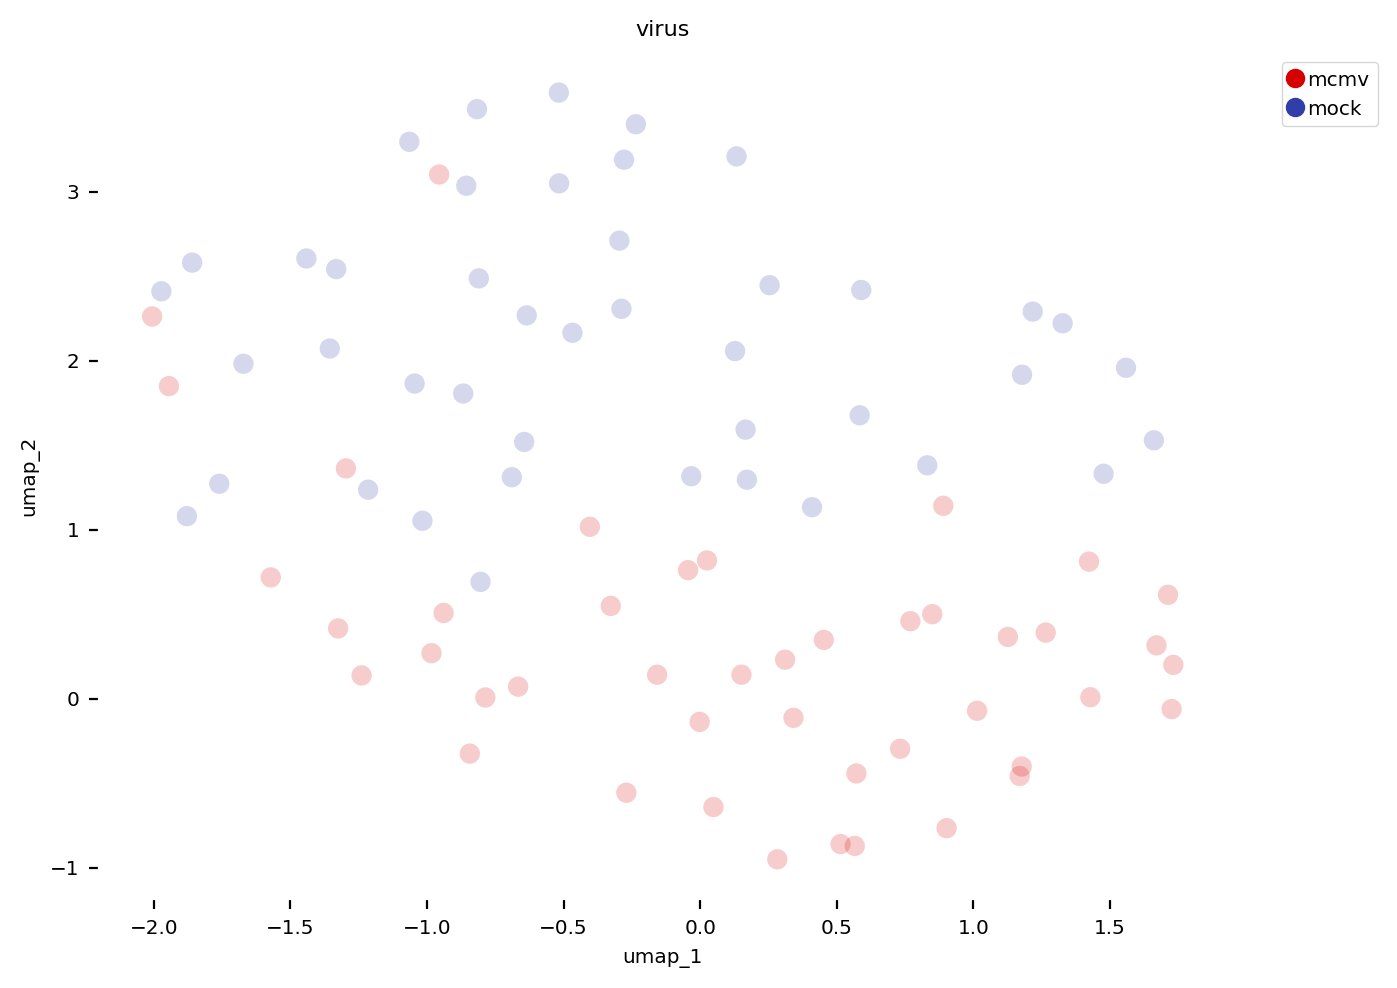

In [14]:
# scv.pp.filter_and_normalize(adata_sc_slamseq_MCMV, min_counts=1, min_counts_u=1, n_top_genes=583)
# scv.pp.moments(adata_sc_slamseq_MCMV, n_pcs = 10, n_neighbors = 15, mode = 'distances') # 
# scv.tl.velocity(adata_sc_slamseq_MCMV)
# scv.tl.velocity_graph(adata_sc_slamseq_MCMV)

dyn.tl.dynamics(adata_sc_slamseq_MCMV, mode='deterministic', use_smoothed=False)
dyn.tl.reduceDimension(adata_sc_slamseq_MCMV)

dyn.pl.umap(adata_sc_slamseq_MCMV, color='virus')

/home/xqiu/.local/lib/python3.6/site-packages/anndata/core/anndata.py:1475: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning


<Figure size 650x500 with 0 Axes>

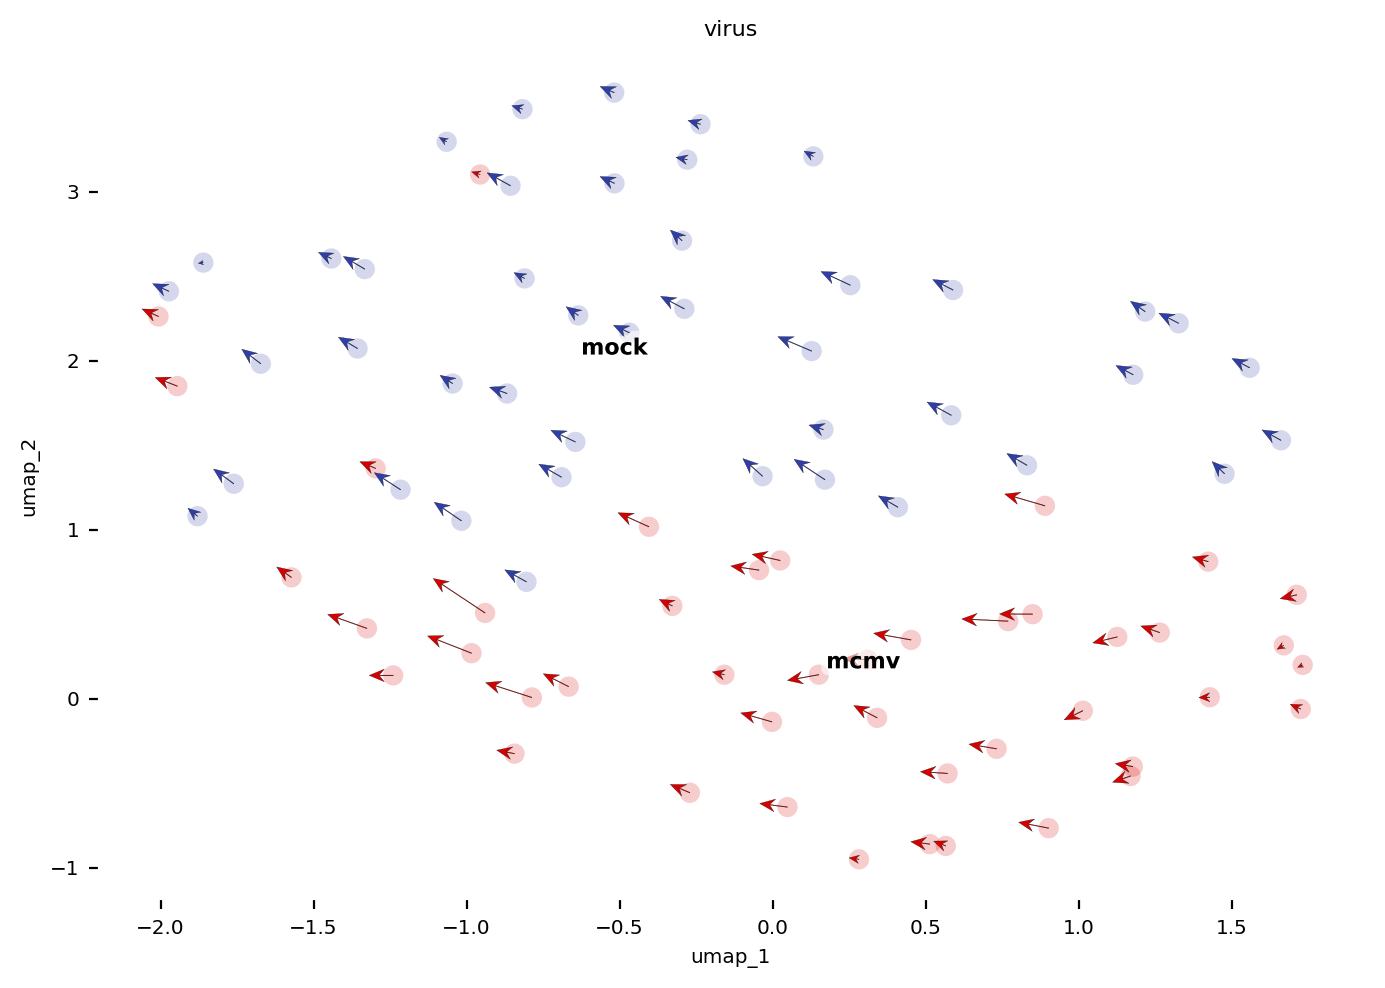

In [15]:
dyn.pl.cell_wise_velocity(adata_sc_slamseq_MCMV, color=['virus'], basis='umap', quiver_size=2, show_legend='on data') # ['GRIA3', 'LINC00982', 'AFF2']


/home/xqiu/.local/lib/python3.6/site-packages/anndata/core/anndata.py:1475: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning


<Figure size 650x500 with 0 Axes>

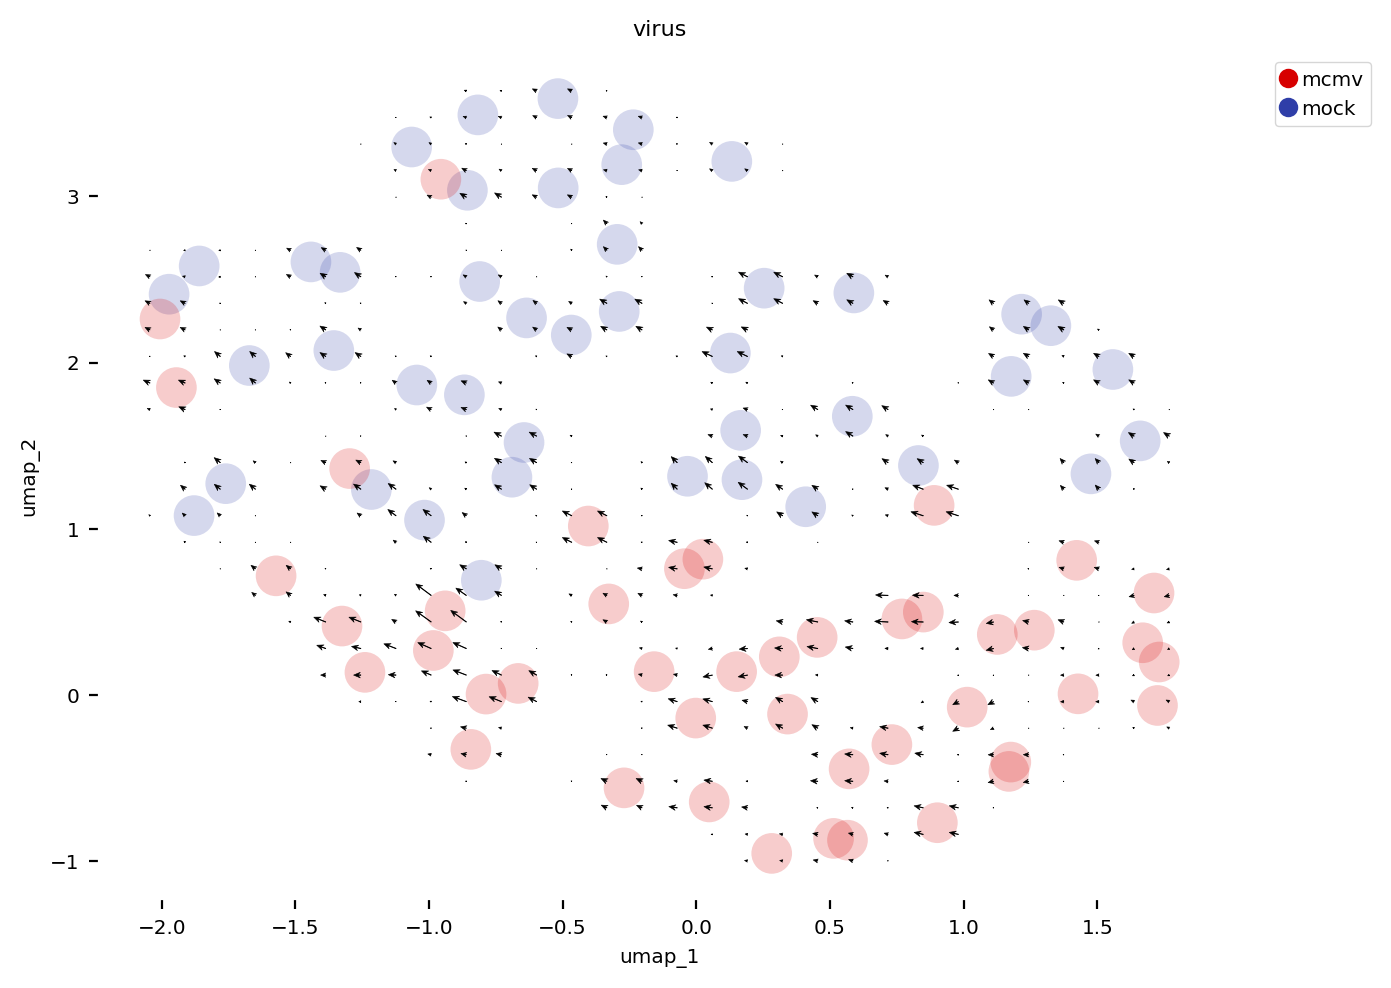

In [16]:

dyn.pl.grid_velocity(adata_sc_slamseq_MCMV, color=['virus'], basis='umap', method='gaussian') # ['GRIA3', 'LINC00982', 'AFF2']



/home/xqiu/.local/lib/python3.6/site-packages/anndata/core/anndata.py:1475: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning


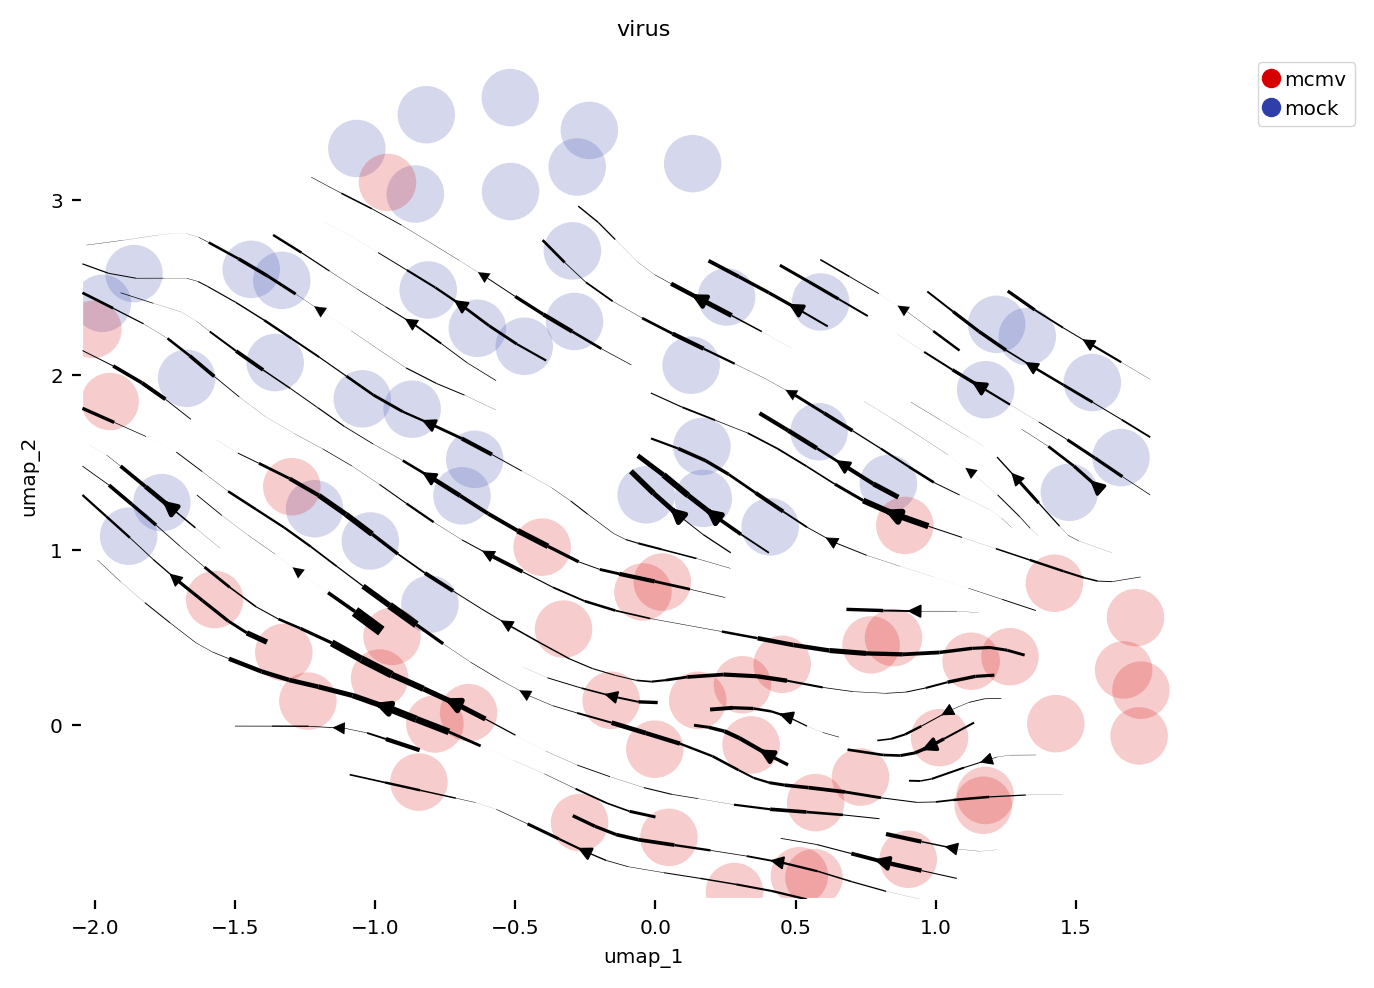

In [17]:
dyn.pl.streamline_plot(adata_sc_slamseq_MCMV, color=['virus'], basis='umap', method='gaussian') # ['GRIA3', 'LINC00982', 'AFF2']


In [18]:
dyn.tl.VectorField(adata_sc_slamseq_MCMV, basis='umap')


/home/xqiu/.local/lib/python3.6/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


AnnData object with n_obs × n_vars = 87 × 583 
    obs: 'virus', 'Size_Factor', 'spliced_Size_Factor', 'unspliced_Size_Factor', 'use_for_dynamo'
    var: 'pass_basic_filter', 'use_for_dynamo', 'beta', 'gamma', 'half_life', 'alpha_b', 'alpha_r2', 'gamma_b', 'gamma_r2', 'delta_b', 'delta_r2', 'uu0', 'ul0', 'su0', 'sl0', 'U0', 'S0', 'total0', 'use_for_velocity'
    uns: 'explained_variance_ratio_', 'pca_fit', 'feature_selection', 'dynamics', 'neighbors', 'kmc', 'transition_matrix', 'grid_velocity_umap', 'VecFld_umap'
    obsm: 'X_pca', 'X_umap', 'velocity_umap'
    layers: 'unspliced', 'spliced', 'X_unspliced', 'X_spliced', 'velocity_S'

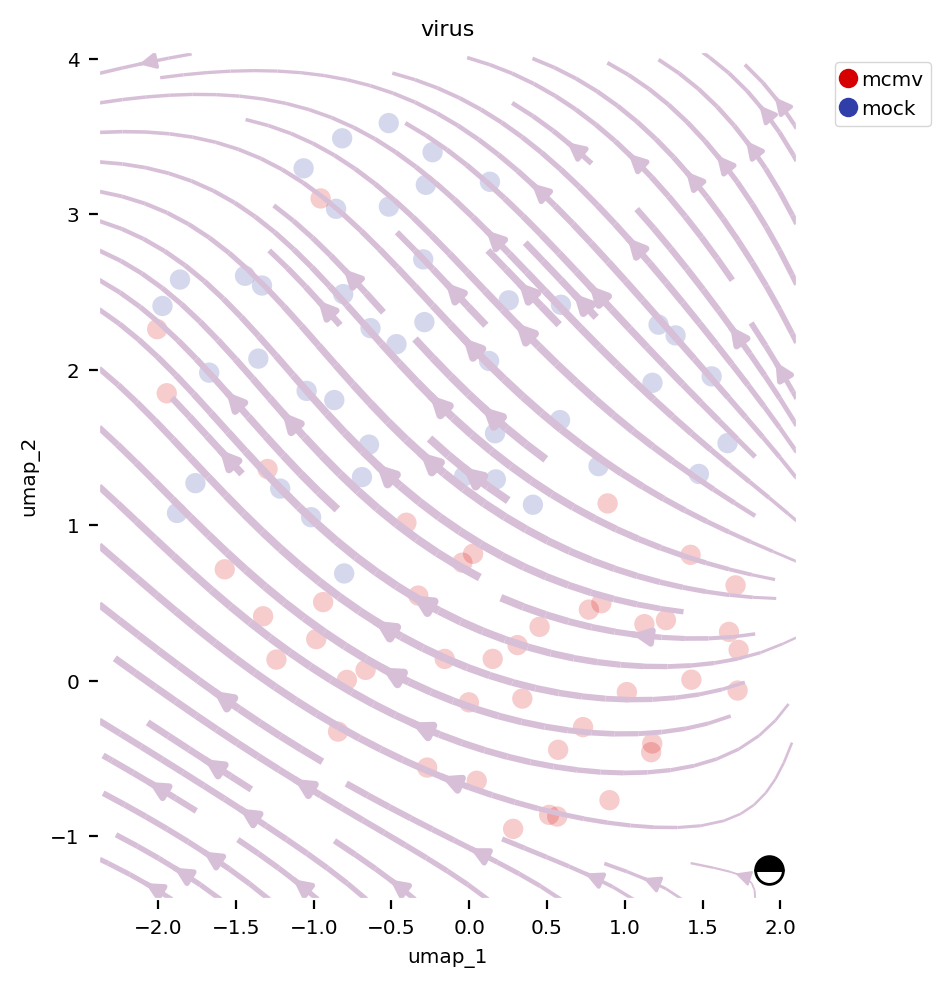

In [19]:
dyn.pl.topography(adata_sc_slamseq_MCMV, color=['virus'], basis='umap', terms=('streamline', 'fixed_points', 'trajectory'))


<Figure size 650x500 with 0 Axes>

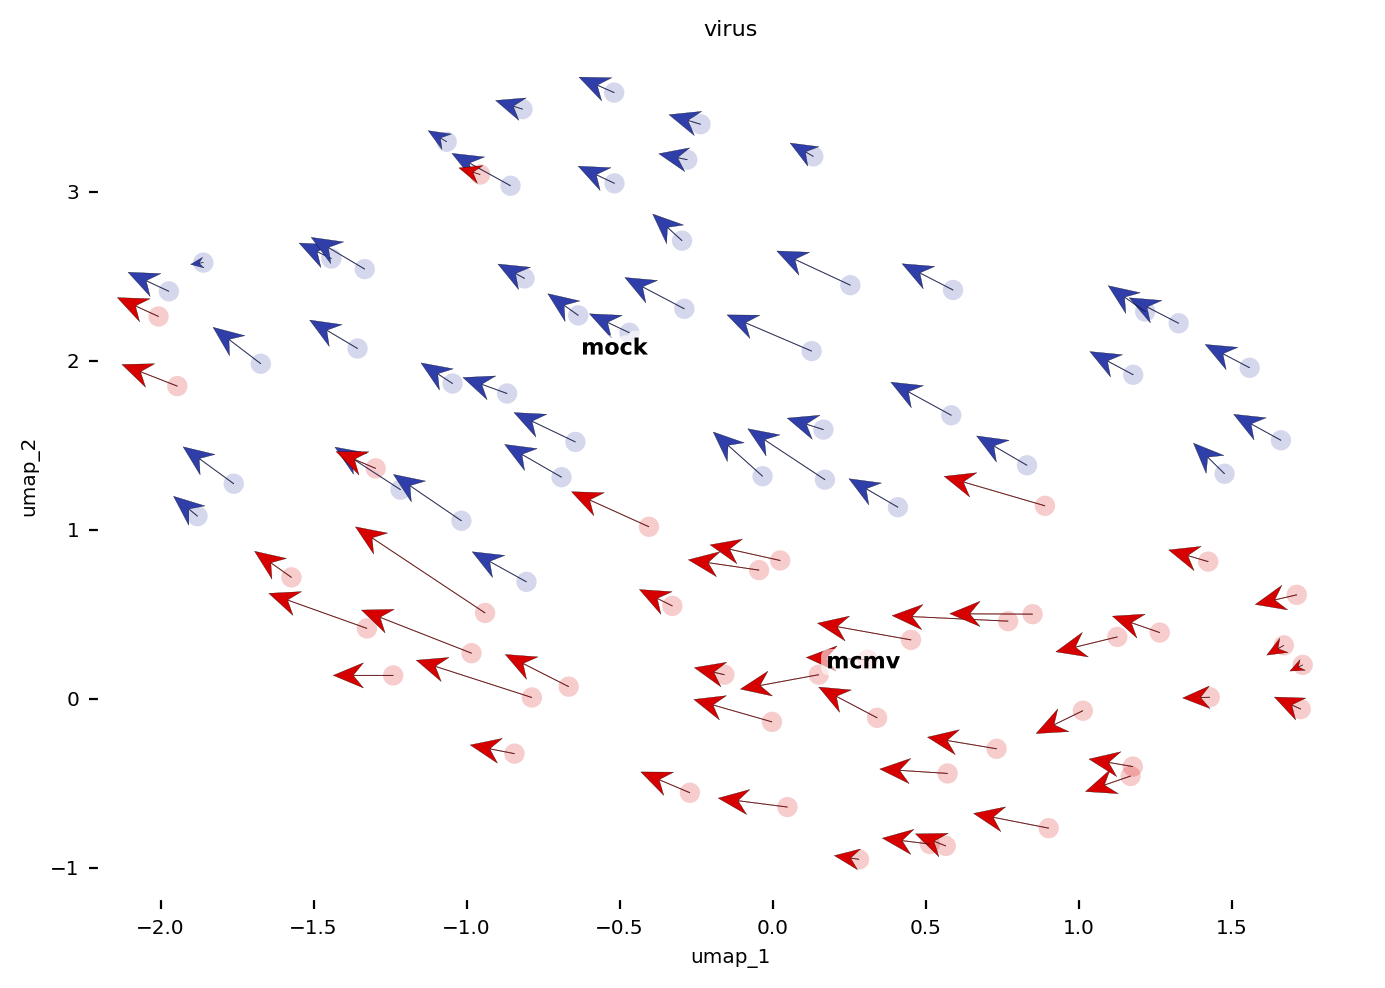

In [20]:
dyn.pl.cell_wise_velocity(adata_sc_slamseq_MCMV, color=['virus'], basis='umap', quiver_size=4, quiver_length=5, show_legend='on data') # ['GRIA3', 'LINC00982', 'AFF2']


<Figure size 650x500 with 0 Axes>

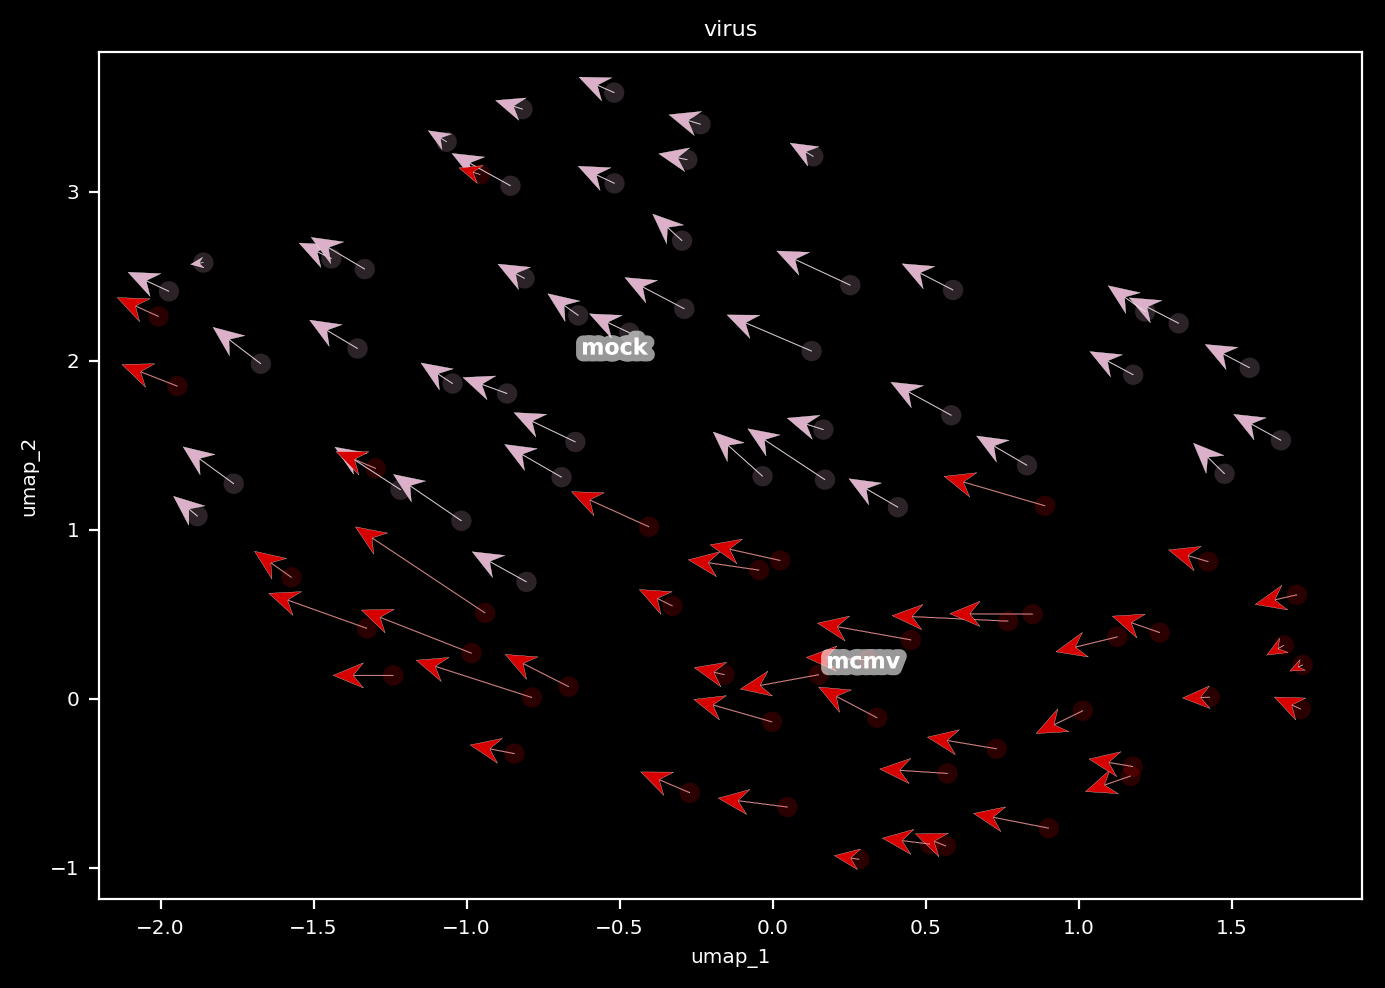

In [21]:
dyn.pl.cell_wise_velocity(adata_sc_slamseq_MCMV, color=['virus'], basis='umap', 
                          quiver_size=4, quiver_length=5, show_legend='on data', background='black') # ['GRIA3', 'LINC00982', 'AFF2']


/home/xqiu/.local/lib/python3.6/site-packages/anndata/core/anndata.py:1475: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning


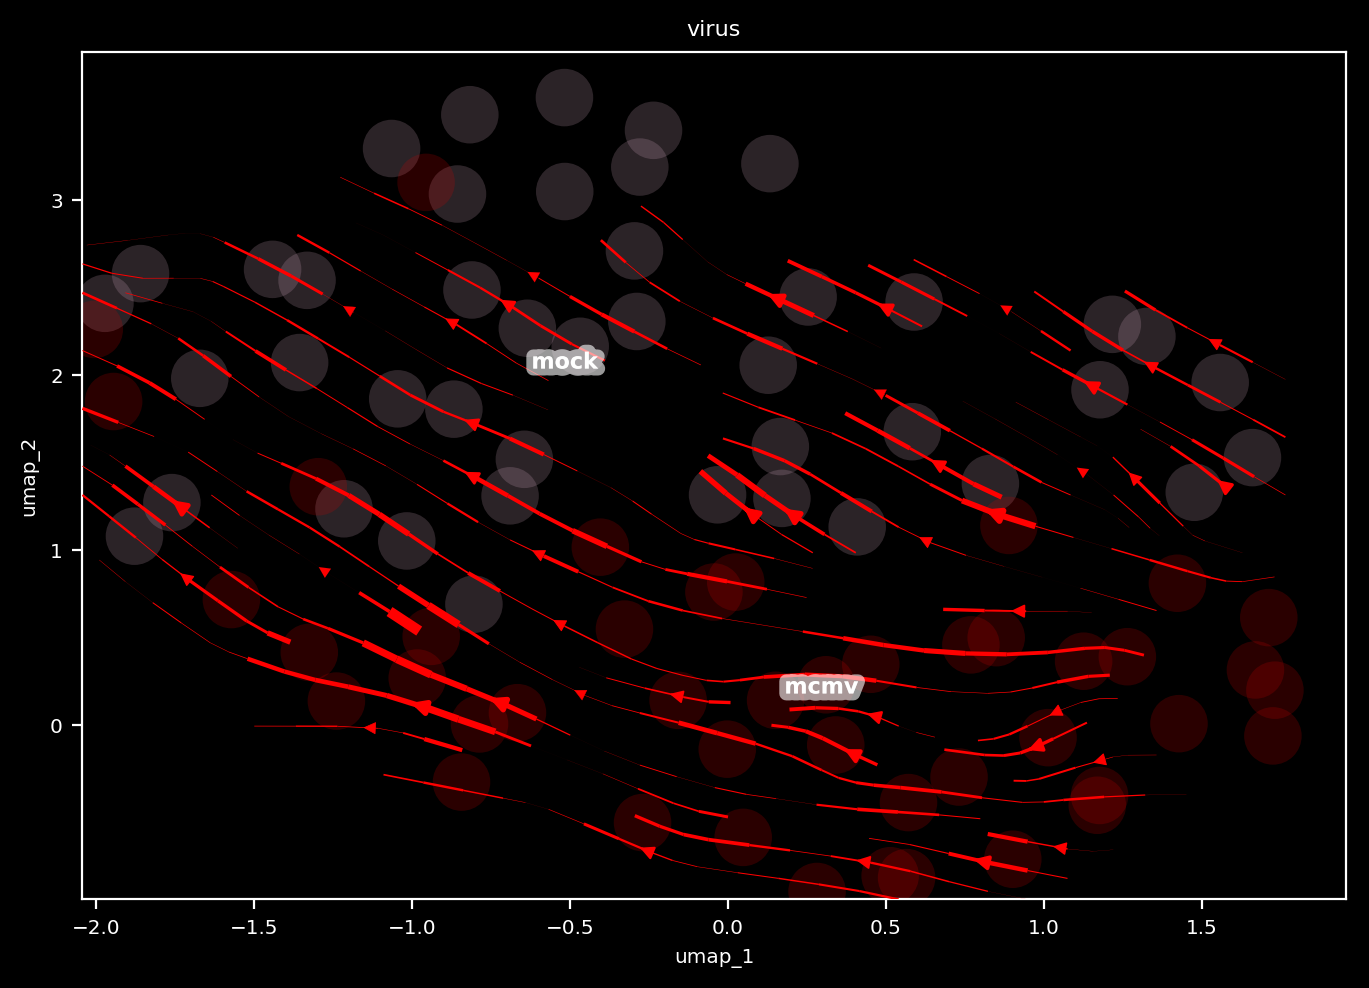

In [22]:
dyn.pl.streamline_plot(adata_sc_slamseq_MCMV, color=['virus'], basis='umap', show_legend='on data', background='black') # ['GRIA3', 'LINC00982', 'AFF2']


the velocity estimation here is much more apparent and consistent. let us save the result 